# Autoencoder Analysis

## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm

from models.AE import Autoencoder
from utils.loaders import load_mnist, load_model

In [2]:
# run params
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])


## Load the data

In [3]:
(x_train, y_train), (x_test, y_test) = load_mnist()

## Load the model architecture

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

z_dim = 2

encoder_input = keras.Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(32, 3, strides=1, padding="same", name='encoder_conv_0')(encoder_input)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=1, padding="same", name='encoder_conv_3')(x)
x = LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
encoder_output= Dense(z_dim, name='encoder_output')(x)
encoder = keras.Model(encoder_input, encoder_output)

encoder.summary()

decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=1, padding="same", name='decoder_conv_t0')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(1, 3, strides=1, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

decoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)         

In [14]:
class AutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def call(self,inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)

@tf.function
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])


In [15]:

save_folder = os.path.join(RUN_FOLDER, 'weights')
AE = AutoEncoder(encoder, decoder)
#AE = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})
AE.load_weights(save_folder+'/'+'checkpoint')


## reconstructing original paintings

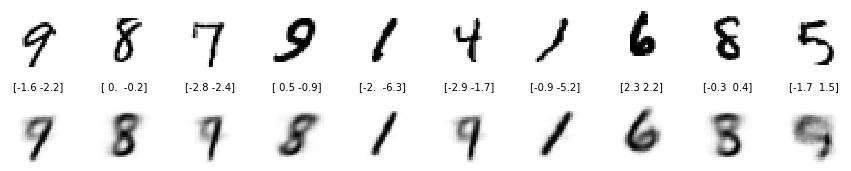

In [17]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images)

reconst_images = AE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


## Mr N. Coder's wall

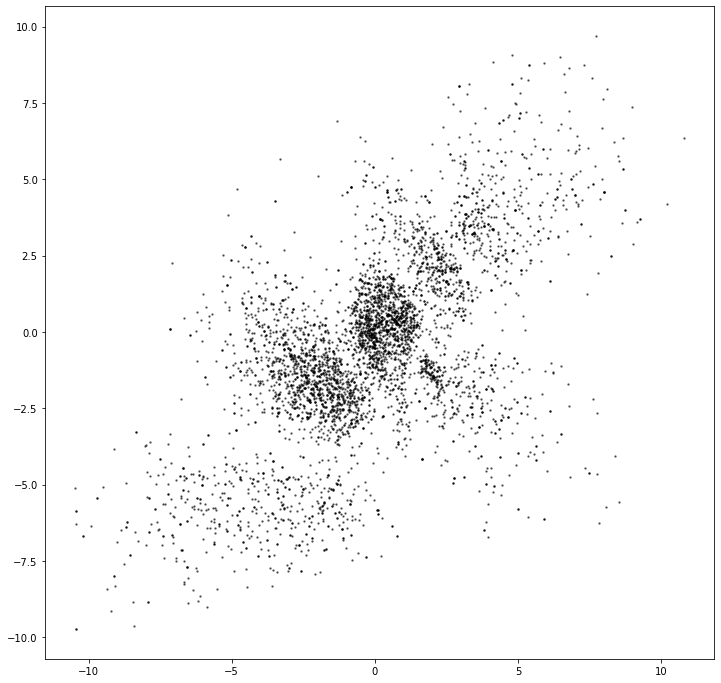

In [18]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

### The new generated art exhibition

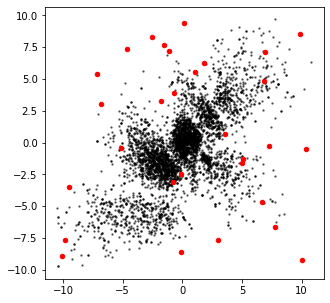

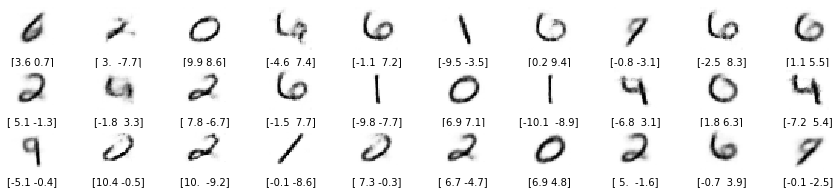

In [19]:
figsize = 5

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

grid_size = 10
grid_depth = 3
figsize = 15

x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))
reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

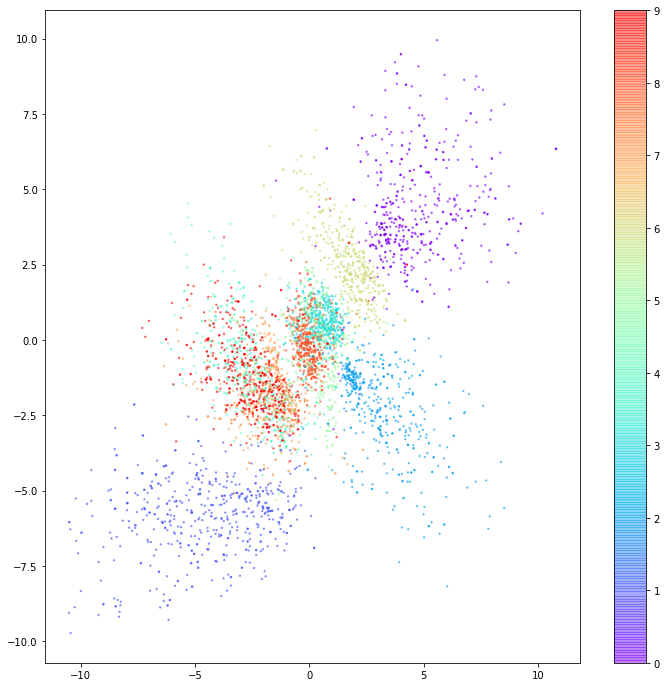

In [30]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

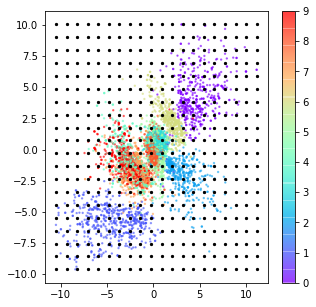

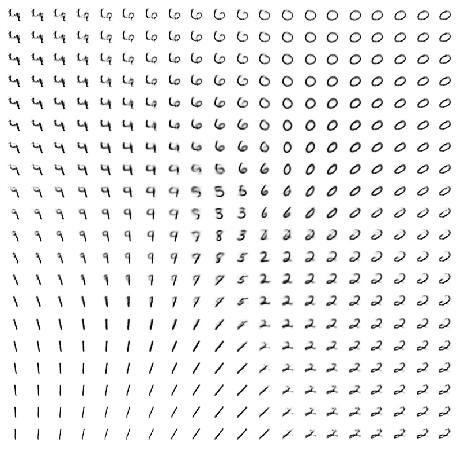

In [20]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')